# Import module

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
import torch.nn.init as init

In [7]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version : ',torch.__version__,'Device :',DEVICE)

Using PyTorch version :  1.11.0 Device : cpu


# Parameter

In [8]:
BATCH_SIZE = 32
EPOCHS = 1

# Data Load

In [10]:
train_dataset = datasets.FashionMNIST(root = "../FashionMNIST/data/FashionMNIST",   # 보통 pandas로 받아오나, 이번에는 pytorchVision에서 받아옴  MNIST 객체
                                train = True,   # train과 test 분리
                                download = True,
                                transform = transforms.ToTensor()) # 이미지를 텐서로 변경
test_dataset = datasets.FashionMNIST(root = "../FashionMNIST/data/FashionMNIST",
                                train = False,
                                transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,   # 각각의 minibatch 로 묶어줌    DataLoad 객체
                                            batch_size = BATCH_SIZE, # 32개의 batchsize 가  하나의 minibatch 이룸
                                            shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = False)                                           

# Check Data

In [11]:
n=0
for i in train_loader :  # 이터러블 객체. 
    n +=1   
    print(i)  #  i 는   트레인 데이터셋은  (3차원텐서, 스칼라)           로드 후 [ 4차원텐서 , 1차원텐서  ] 형식으로 이루어짐    
    print(i[0].size())  # 데이터 로드 하기 전에는 1 , 28 , 28  50           로드 한 후에 32, 1, 28, 28       이미지데이터수 , 채널 , 가로 , 세로    5041
    if n ==2 :                #   즉 모든 수 들이 32개씩 묶인다. 5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
                                                                #1, 2, 4, 3, 2, 7, 3, 8
        break


# 즉 트레인 데이터셋에서  데이터로드 함수를 이용해서 미니배치로 묶어준 것이다.

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

In [12]:
for (X_train, Y_train) in train_loader:
    print("X_tran:", X_train.size(), 'type : ', X_train.type())
    print("Y_tran:", Y_train.size(), 'type : ', Y_train.type())
    break

X_tran: torch.Size([32, 1, 28, 28]) type :  torch.FloatTensor
Y_tran: torch.Size([32]) type :  torch.LongTensor


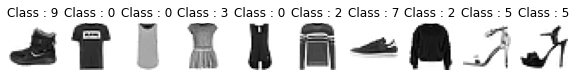

In [13]:
pltsize = 1   #5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1 , 1, 2, 4, 3, 2, 7, 3, 8   하나의 미니배치이다. 근데, 미니배치 0 번 인덱스인데 왜 5만 나오지 그럼 다음미니배치인 6은 어떻게 ? 아니다. 이게 맞다.  32개가 있다는것은 ,  미니배치가 32개라는 말이 아니라, 한개의 미니배치 안에 32개의 데이터가 있다는 말이다. 그래서 다음 데이터가 맞다.  다음 미니배치를 불러오려면??
                                                               
plt.figure(figsize=(10 * pltsize, pltsize))
#plt.imshow(X_train[3,:,:,:].reshape(28,28))    

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28),cmap = "gray_r")   # 한 미니배치의 각 데이터, 채널 , 가로 , 세로  >> 가로 , 세로
    plt.title('Class : '+str(Y_train[i].item()))

# Module

In [20]:
class AE(nn.Module) : # pytorch 모듈 내에 nn.Module 상속         
    def __init__(self):  # 생성자 풀리커넥티드 레이어 생성
        super(AE,self).__init__()  # nn.Module 메소드 상속받아서 이용
        self.encoder = nn.Sequential(  # 기존에는 노드들만 정의 해놓고 아래에서 호출 해줬는데 이번엔 init 안에 Sequential 을 통해서 인코더 디코더 만들어놓기
            nn.Linear(28*28,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,32))
        self.decoder = nn.Sequential(  # 기존에는 노드들만 정의 해놓고 아래에서 호출 해줬는데 이번엔 init 안에 Sequential 을 통해서 인코더 디코더 만들어놓기
            nn.Linear(32,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,28*28))

    def forward(self,x):   # 순전파.  쭉 흐르는것 계산                             층들을 선형결합으로 통과 > sigmoid > softmax
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded , decoded
        

# Optimizer Objective function

In [21]:
def weight_init(m):  # init 파라미터 He 방식으로 설정
    if isinstance(m,nn.Linear):
        init.kaiming_uniform_(m.weight.data)

In [22]:
model = Net().to(DEVICE)   # 모델 객체 생성
model.apply(weight_init)  # init 파라미터들 설정 

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01 , momentum = 0.5) #역전파할때 이용하는 옵티마이저 설정 > SGD알고리즘으로 설정
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss() # 실제 y 와 ybar 의 Loss 계산 > CrossEntropy 알고리즘 사용

# Train Function

In [23]:
def train(model,train_loader,optimizer, log_interval):  # MLP 모델 학습하는 함수 정의
    model.train() # 모델을 학습상태로 지정
    for batch_idx,(image,label) in enumerate(train_loader):   # 미니배치 k개로 저장된것을 enum 시키고 batch idx와  image와 label 튜플로.. > 즉 한 에폭 수행  그러면 어떻게 되나면 ,,   0 , (32*1*28*28 , 32)   ... 이렇게 된다  첫번째 for문은 첫번째 미니배치, 두번째 는 두번쨰.. 등등
        image = image.to(DEVICE) 
        label = label.to(DEVICE)
        optimizer.zero_grad()      # SGD 알고리즘에서 gradient 초기화
        output = model(image)  # 이미지를 이용해서 미니배치의 결과값 계산  output 은 32개가 있을것이다.
        loss = criterion(output,label) # 계산된 32개의 output과 label 의 32개 값들을 비교해서 loss 를 구한다.
        loss.backward() # CrossEntropyLoss 객체의 역전파 수행
        optimizer.step() # 각 파라ㅣ터에 할당된 gradient 값을 이용해서 파라미터 업데이트  ## 정확히 이게 뭔지 이해가 안간다



In [24]:
def evaluate(model, test_loader):  # 모델의 성능 평가
    model.eval() # 모델을 평가상태로 지정
    test_loss = 0
    correct = 0   # 초기화

    with torch.no_grad() :  # 모델 평가단계에서는 gradient 흐름 제어
        for image,label in test_loader :  # 미니배치로 저장된 테스트로더들,  한 반복문당 하나의 미니배치 수행
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)  # 32,1,28,28 이미지를 input으로  32 텐서의 output 계산
            test_loss += criterion(output,label).item()  # 32개의 output과 label 들의 loss 값을 계산 그리고 이것은 매 미니배치마다 더해진다
            prediction = output.max(1,keepdim = True)[1] # prediction은 32텐서이고, 32개의 수들에 대해서 10개 중 가장 일치하는 값들을 저장  , loss 와 별개로 정확도 예측을위해서 왜 1 index 값이지?
            correct += prediction.eq(label.view_as(prediction)).sum().item() # 최종 예측한 output 과 label 이 일치하면 그 갯수를 더한다. 32개 있으므로 sum

    test_loss /= len(test_loader.dataset) # loss 값을 미니배치 개수 만큼 나눠서 평균값을 구한다.  즉 한 미니배치의 loss 계산한것
    test_accuacy = 100. * correct / len(test_loader.dataset) # 정확도도 마찬가지

    return test_loss , test_accuacy




# Run  and loss accuracy

In [25]:
for Epoch in range(1, EPOCHS+1) :  # 에폭만큼 수행
    train(model, train_loader,optimizer,log_interval=200)  # train 함수실행 (학습실행) 매개변수는 모델, 데이터, 역전파, 관찰값
    test_loss, test_accuracy = evaluate(model, test_loader)  # evaluate 함수실행 > 즉 테스트데이터의 loss accur 구하기

    print("Epoch: {} , test loss : {} , test accur: {}".format(Epoch,test_loss,test_accuracy))

Epoch: 1 , test loss : 0.014502908235788346 , test accur: 83.15
